In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
import logging

from asgardpy.analysis import AsgardpyAnalysis
from asgardpy.config import AsgardpyConfig
from asgardpy.data.target import apply_selection_mask_to_models, set_models

from gammapy.maps import Map
from gammapy.modeling.models import Models
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator
from gammapy.datasets import Datasets

In [2]:
os.environ['GAMMAPY_DATA']

'/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/'

In [3]:
log = logging.getLogger("test DL4 steps")

In [4]:
config_file = "../asgardpy/tests/config_test_base.yaml"

In [5]:
config = AsgardpyConfig()

In [6]:
%%time
config_main = config.read(config_file)

CPU times: user 42.1 ms, sys: 5.43 ms, total: 47.5 ms
Wall time: 44.5 ms


# Update path of test data

In [7]:
config_main.dataset3d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
config_main.dataset3d.instruments[0].input_dl3[1].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
config_main.dataset1d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}hess-dl3-dr1/"

In [8]:
for g in config_main.general:
    print(g)

('log', LogConfig(level='info', filename='', filemode='w', format='', datefmt=''))
('outdir', PosixPath('.'))
('n_jobs', 10)
('parallel_backend', <ParallelBackendEnum.multi: 'multiprocessing'>)
('steps', [<AnalysisStepEnum.datasets_3d: 'datasets-3d'>, <AnalysisStepEnum.datasets_1d: 'datasets-1d'>, <AnalysisStepEnum.fit: 'fit'>, <AnalysisStepEnum.flux_points: 'flux-points'>])
('overwrite', True)
('stacked_dataset', True)


# Steps mentioned in the main config file

In [9]:
config_main.general.steps

[<AnalysisStepEnum.datasets_3d: 'datasets-3d'>,
 <AnalysisStepEnum.datasets_1d: 'datasets-1d'>,
 <AnalysisStepEnum.fit: 'fit'>,
 <AnalysisStepEnum.flux_points: 'flux-points'>]

In [10]:
for c in config_main.target:
    print(c)

('source_name', '4FGL J0534.5+2201i')
('sky_position', SkyPositionConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 83.633 deg>, lat=<Angle 22.02 deg>, radius=<Angle 0. deg>))
('use_uniform_position', True)
('models_file', PosixPath('.'))
('add_fov_bkg_model', False)
('use_catalog', CatalogConfig(name='', selection_radius=<Angle 0. deg>, exclusion_radius=<Angle 0. deg>))
('components', [SkyModelComponent(name='4FGL J0534.5+2201i', type='SkyModel', spectral=SpectralModelConfig(type='LogParabolaSpectralModel', parameters=[ModelParams(name='amplitude', value=1e-06, unit='cm-2 s-1 TeV-1', error=1.5e-07, min=1e-13, max=0.01, frozen=False), ModelParams(name='reference', value=0.01, unit='TeV', error=0.0, min=0.0001, max=100.0, frozen=True), ModelParams(name='alpha', value=1.7, unit='', error=0.1, min=0.5, max=5.0, frozen=False), ModelParams(name='beta', value=0.1, unit='', error=0.001, min=1e-06, max=1.0, frozen=False)], ebl_abs=EBLAbsorptionModel(filename=PosixPath('.'), reference='domingue

# Datasets informations

In [11]:
for cc in config_main.dataset3d:
    print(cc)

('type', <ReductionTypeEnum.cube: '3d'>)
('instruments', [Dataset3DBaseConfig(name='Fermi-LAT', input_dl3=[InputDL3Config(type='lat', input_dir=PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab'), glob_pattern={'events': '*ft*.fits*', 'edisp': 'drm*.fits*', 'xml_model': 'srcmdl*.xml', 'exposure': 'bexpmap*.fits*', 'psf': 'psf*.fits*'}), InputDL3Config(type='lat-aux', input_dir=PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab'), glob_pattern={'gal_diffuse': 'gll_iem_v07_cutout.fits*', 'iso_diffuse': 'iso_P8R3_SOURCE_V3_*.txt'})], input_dl4=False, dataset_info=Dataset3DInfoConfig(name='Fermi-LAT', key=['00', '01'], observation=ObservationsConfig(obs_ids=[], obs_file=PosixPath('.'), obs_time=TimeIntervalsConfig(format=<TimeFormatEnum.iso: 'iso'>, intervals=[TimeRangeConfig(start=<Time object: scale='utc' format='mjd' value=0.0>, stop=<Time object: scale='utc' format='mjd' value=0.0>)])

In [12]:
for cc in config_main.dataset1d:
    print(cc)

('type', <ReductionTypeEnum.spectrum: '1d'>)
('instruments', [Dataset1DBaseConfig(name='HESS', input_dl3=[InputDL3Config(type='gadf-dl3', input_dir=PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/hess-dl3-dr1'), glob_pattern={'dl3': 'data/hess_*fits.gz'})], input_dl4=False, dataset_info=Dataset1DInfoConfig(name='HESS', geom=GeomConfig(wcs=WcsConfig(skydir=SkyPositionConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 0. deg>, lat=<Angle 0. deg>, radius=<Angle 0. deg>), binsize=<Angle 0.02 deg>, proj=<ProjectionEnum.tan: 'TAN'>, map_frame_shape=MapFrameShapeConfig(width=<Angle 6. deg>, height=<Angle 6. deg>), binsize_irf=<Angle 0.2 deg>), selection=SelectionConfig(offset_max=<Angle 2.5 deg>), axes=[MapAxesConfig(name='energy', axis=EnergyAxisConfig(min=<Quantity 0.1 TeV>, max=<Quantity 100. TeV>, nbins=5, per_decade=True), axis_custom=EnergyEdgesCustomConfig(edges=[], unit='TeV')), MapAxesConfig(name='energy_true', axis=EnergyAxisConfig(min=<Quanti

# DL4 step information

In [13]:
for cc in config_main.fit_params:
    print(cc)

('fit_range', EnergyRangeConfig(min=<Quantity 1. GeV>, max=<Quantity 40. TeV>))
('backend', <BackendEnum.minuit: 'minuit'>)
('optimize_opts', {})
('covariance_opts', {})
('confidence_opts', {})
('store_trace', True)


In [14]:
for cc in config_main.flux_points_params:
    print(cc)

('parameters', {'selection_optional': 'all'})
('reoptimize', False)


In [15]:
%%time
analysis = AsgardpyAnalysis(config_main)

Setting logging config: {'level': 'INFO', 'filename': '', 'filemode': 'w', 'format': '', 'datefmt': ''}


CPU times: user 489 µs, sys: 1.15 ms, total: 1.63 ms
Wall time: 1.19 ms


In [16]:
analysis

# Prepare the dataset

In [17]:
instruments_list_3d = config_main.dataset3d.instruments
print(len(instruments_list_3d), "number of 3D dataset information provided")

config_3d_dataset = instruments_list_3d[0]
print(f"Instrument selected is {config_3d_dataset.name}")

1 number of 3D dataset information provided
Instrument selected is Fermi-LAT


In [18]:
instruments_list_1d = config_main.dataset1d.instruments
print(len(instruments_list_1d), "number of 1D dataset information provided")

config_1d_dataset = instruments_list_1d[0]
print(f"Instrument selected is {config_1d_dataset.name}")

1 number of 1D dataset information provided
Instrument selected is HESS


In [19]:
key_names = config_3d_dataset.dataset_info.key
print(f"The list of different keys or modes of observations for the selected instrument are {key_names}")

The list of different keys or modes of observations for the selected instrument are ['00', '01']


# Run each Dataset nD Generation step

In [20]:
%%time
analysis.run(["datasets-3d"])

Perform DL3 to DL4 process!
1 number of 3D Datasets given
The different keys used: 00 01
Selecting the file with name containing 00
Selecting the file with name containing 00
Selecting the file with name containing 00
Selecting the file with name containing 00
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'.
Using the exclusion mask to create a safe mask
Selecting the file with name containing 01
Selecting the file with name containing 01
Selecting the file with name containing 01
Selecting the file with name containing 01
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'. [astr

CPU times: user 11 s, sys: 413 ms, total: 11.5 s
Wall time: 11.5 s


## Display some results

In [21]:
print(analysis.datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT_00
  Instrument : 
  Models     : ['4FGL J0534.5+2201i', '4FGL J0534.5+2201s', '4FGL J0534.5+2200', '4FGL J0526.3+2246', '4FGL J0544.4+2238', '4FGL J0528.3+1817', '4FGL J0536.2+1733', '4FGL J0550.9+2552c', '4FGL J0539.0+1644', '4FGL J0534.2+2751', '4FGL J0540.3+2756e', 'fermi-diffuse-iso-00', 'diffuse-iem']

Dataset 1: 

  Type       : MapDataset
  Name       : Fermi-LAT_01
  Instrument : 
  Models     : ['4FGL J0534.5+2201i', '4FGL J0534.5+2201s', '4FGL J0534.5+2200', '4FGL J0526.3+2246', '4FGL J0544.4+2238', '4FGL J0528.3+1817', '4FGL J0536.2+1733', '4FGL J0550.9+2552c', '4FGL J0539.0+1644', '4FGL J0534.2+2751', '4FGL J0540.3+2756e', 'diffuse-iem', 'fermi-diffuse-iso-01']




In [ ]:
print(analysis.final_model)

In [ ]:
for m in analysis.final_model:
    print(m)

In [24]:
print(analysis.instrument_spectral_info)

{'name': ['Fermi-LAT'], 'spectral_energy_ranges': [<Quantity [  1.        ,   1.77827941,   3.16227766,   5.62341325,
            10.        ,  17.7827941 ,  31.6227766 ,  56.23413252,
           100.        , 177.827941  , 316.22776602, 562.34132519] GeV>], 'en_bins': 48, 'free_params': 8, 'DoF': 40}


In [25]:
print(analysis.dataset_name_list)

['Fermi-LAT_00', 'Fermi-LAT_01']


In [26]:
%%time
analysis.run(["datasets-1d"])

Perform DL3 to DL4 process!
1 number of 1D Datasets given
Observation ID list selected: 23523 23526
Observations selected: 2 out of 2.
Using 2 processes to compute Data reduction
Computing dataset for observation 23523
Running SpectrumDatasetMaker
Computing dataset for observation 23526
Running SpectrumDatasetMaker
Running SafeMaskMaker
Running SafeMaskMaker
Running ReflectedRegionsBackgroundMaker
Running ReflectedRegionsBackgroundMaker
Analysis Step datasets-1d completed
Models have been associated with the Datasets


CPU times: user 253 ms, sys: 58.1 ms, total: 311 ms
Wall time: 1.12 s


## Display the results

In [27]:
print(analysis.datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT_00
  Instrument : 
  Models     : ['4FGL J0534.5+2201i', '4FGL J0534.5+2201s', '4FGL J0534.5+2200', '4FGL J0526.3+2246', '4FGL J0544.4+2238', '4FGL J0528.3+1817', '4FGL J0536.2+1733', '4FGL J0550.9+2552c', '4FGL J0539.0+1644', '4FGL J0534.2+2751', '4FGL J0540.3+2756e', 'fermi-diffuse-iso-00', 'diffuse-iem']

Dataset 1: 

  Type       : MapDataset
  Name       : Fermi-LAT_01
  Instrument : 
  Models     : ['4FGL J0534.5+2201i', '4FGL J0534.5+2201s', '4FGL J0534.5+2200', '4FGL J0526.3+2246', '4FGL J0544.4+2238', '4FGL J0528.3+1817', '4FGL J0536.2+1733', '4FGL J0550.9+2552c', '4FGL J0539.0+1644', '4FGL J0534.2+2751', '4FGL J0540.3+2756e', 'diffuse-iem', 'fermi-diffuse-iso-01']

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : HESS
  Instrument : 
  Models     : ['4FGL J0534.5+2201i']




In [28]:
for d in analysis.datasets:
    print(d)

/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : Fermi-LAT_00 

  Total counts                    : 29220 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 29091.28
  Predicted background counts     : nan
  Predicted excess counts         : 29091.28

  Exposure min                    : 5.77e+10 cm2 s
  Exposure max                    : 7.23e+10 cm2 s

  Number of total bins            : 1182816 
  Number of fit bins              : 269424 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 50348.00

  Number of models                : 13 
  Number of parameters            : 71
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : 4FGL J0534.5+2201i
    Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS']
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : Fermi-LAT_01 

  Total counts                    : 28810 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 28570.86
  Predicted background counts     : nan
  Predicted excess counts         : 28570.86

  Exposure min                    : 4.50e+10 cm2 s
  Exposure max                    : 6.52e+10 cm2 s

  Number of total bins            : 1182816 
  Number of fit bins              : 269424 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 73763.87

  Number of models                : 13 
  Number of parameters            : 71
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : 4FGL J0534.5+2201i
    Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS']
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

In [ ]:
for m in analysis.final_model:
    print(m)

In [30]:
print(analysis.instrument_spectral_info)

{'name': ['Fermi-LAT', 'HESS'], 'spectral_energy_ranges': [<Quantity [  1.        ,   1.77827941,   3.16227766,   5.62341325,
            10.        ,  17.7827941 ,  31.6227766 ,  56.23413252,
           100.        , 177.827941  , 316.22776602, 562.34132519] GeV>, <Quantity [1.00000000e-01, 1.58489319e-01, 2.51188643e-01, 3.98107171e-01,
           6.30957344e-01, 1.00000000e+00, 1.58489319e+00, 2.51188643e+00,
           3.98107171e+00, 6.30957344e+00, 1.00000000e+01, 1.58489319e+01,
           2.51188643e+01, 3.98107171e+01, 6.30957344e+01, 1.00000000e+02] TeV>], 'en_bins': 63, 'free_params': 17, 'DoF': 46}


In [31]:
for i, en_range in enumerate(analysis.instrument_spectral_info["spectral_energy_ranges"]):
    print(f"The spectral energy range to be used for dataset {analysis.instrument_spectral_info['name'][i]} is {en_range}")

The spectral energy range to be used for dataset Fermi-LAT is [  1.           1.77827941   3.16227766   5.62341325  10.
  17.7827941   31.6227766   56.23413252 100.         177.827941
 316.22776602 562.34132519] GeV
The spectral energy range to be used for dataset HESS is [1.00000000e-01 1.58489319e-01 2.51188643e-01 3.98107171e-01
 6.30957344e-01 1.00000000e+00 1.58489319e+00 2.51188643e+00
 3.98107171e+00 6.30957344e+00 1.00000000e+01 1.58489319e+01
 2.51188643e+01 3.98107171e+01 6.30957344e+01 1.00000000e+02] TeV


In [32]:
print(analysis.dataset_name_list)

['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS']


# Preparing the Datasets for DL4 steps

In [33]:
analysis.final_model = Models(analysis.final_model)

In [34]:
# Only updating the target source model with names of all datasets
if len(analysis.final_model) > 1:
    analysis.final_model = apply_selection_mask_to_models(
        list_sources=analysis.final_model,
        target_source=analysis.config.target.source_name,
        roi_radius=analysis.config.target.roi_selection.roi_radius,
        free_sources=analysis.config.target.roi_selection.free_sources,
    )

In [ ]:
for model_ in analysis.final_model:
    print(model_)

## Assigning the models to all the datasets

In [36]:
analysis.datasets, analysis.final_model = set_models(
    analysis.config.target,
    analysis.datasets,
    analysis.dataset_name_list,
    models=analysis.final_model,
)

In [37]:
%%time
for d in analysis.datasets:
    print(d)      

/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : Fermi-LAT_00 

  Total counts                    : 29220 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 29091.28
  Predicted background counts     : nan
  Predicted excess counts         : 29091.28

  Exposure min                    : 5.77e+10 cm2 s
  Exposure max                    : 7.23e+10 cm2 s

  Number of total bins            : 1182816 
  Number of fit bins              : 269424 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 50348.00

  Number of models                : 13 
  Number of parameters            : 71
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : 4FGL J0534.5+2201i
    Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS']
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : Fermi-LAT_01 

  Total counts                    : 28810 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 28570.86
  Predicted background counts     : nan
  Predicted excess counts         : 28570.86

  Exposure min                    : 4.50e+10 cm2 s
  Exposure max                    : 6.52e+10 cm2 s

  Number of total bins            : 1182816 
  Number of fit bins              : 269424 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 73763.87

  Number of models                : 13 
  Number of parameters            : 71
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : 4FGL J0534.5+2201i
    Datasets names            : ['Fermi-LAT_00', 'Fermi-LAT_01', 'HESS']
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

In [38]:
len(list(analysis.final_model.parameters.free_parameters))

9

# Run the Fit step

In [39]:
%%time
analysis.run(["fit"])

Perform DL4 to DL5 processes!
OptimizeResult

	backend    : BackendEnum.minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 261
	total stat : 120169.36

CovarianceResult

	backend    : BackendEnum.minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Analysis Step fit completed
The Chi2/dof value of the goodness of Fit is 67.25/46
and the p-value is 2.213e-02 and in Significance 2.29 sigmas
with TS (H0) as -4452.830 and TS (H1) as -4520.080


CPU times: user 1min 19s, sys: 11.1 s, total: 1min 30s
Wall time: 1min 30s


In [40]:
print(analysis.fit_result)

OptimizeResult

	backend    : BackendEnum.minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 261
	total stat : 120169.36

CovarianceResult

	backend    : BackendEnum.minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [ ]:
for m in analysis.datasets[0].models:
    print(m)

# Run the Flux Points Estimator step

In [42]:
%%time
analysis.run(["flux-points"])

Perform DL4 to DL5 processes!
Using 10 processes to compute Energy bins
/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)
/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values

CPU times: user 9.53 s, sys: 11.9 s, total: 21.5 s
Wall time: 2min 5s


In [43]:
for fp in analysis.flux_points:
    print(fp)

FluxPoints
----------

  geom                   : RegionGeom
  axes                   : ['lon', 'lat', 'energy']
  shape                  : (1, 1, 11)
  quantities             : ['norm', 'norm_err', 'norm_errn', 'norm_errp', 'norm_ul', 'ts', 'npred', 'npred_excess', 'stat', 'counts', 'success', 'stat_scan']
  ref. model             : compound
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : likelihood

FluxPoints
----------

  geom                   : RegionGeom
  axes                   : ['lon', 'lat', 'energy']
  shape                  : (1, 1, 15)
  quantities             : ['norm', 'norm_err', 'norm_errn', 'norm_errp', 'norm_ul', 'ts', 'npred', 'npred_excess', 'stat', 'counts', 'success', 'stat_scan']
  ref. model             : compound
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : likelihood



In [44]:
fermi_fpt = analysis.flux_points[0].to_table(sed_type="e2dnde", formatted=True)
fermi_fpt

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[2],float32[2],float64,bool,float64[2],bool,float64[11],float64[11]
0.001,0.001,0.002,1.728e-11,2.235e-12,2.243e-12,2.228e-12,2.178e-11,62.979,7.936,15345.396984523384 .. 15232.64119690531,437.87695 .. 434.8675,44052.361,False,16088.0 .. 15605.0,True,0.200 .. 5.000,44093.151 .. 44770.953
0.002,0.002,0.003,1.891e-11,2.620e-12,2.632e-12,2.608e-12,2.419e-11,55.823,7.471,7573.6624179725095 .. 7423.148651483705,285.64978 .. 280.4052,34610.865,False,7559.0 .. 7636.0,True,0.200 .. 5.000,34640.704 .. 35798.004
0.004,0.003,0.006,3.970e-11,3.246e-12,3.268e-12,3.225e-12,4.628e-11,179.112,13.383,3451.8741146737348 .. 3410.073203866996,331.09457 .. 326.9443,20004.770,False,3235.0 .. 3342.0,True,0.200 .. 5.000,20122.210 .. 21147.666
0.007,0.006,0.010,5.105e-11,3.806e-12,3.843e-12,3.769e-12,5.882e-11,248.658,15.769,1559.6068050448844 .. 1503.359152552588,242.86526 .. 233.99243,9831.720,False,1308.0 .. 1266.0,True,0.200 .. 5.000,9986.988 .. 11047.243
0.013,0.010,0.018,5.494e-11,4.287e-12,4.351e-12,4.221e-12,6.375e-11,286.132,16.915,683.4009377327534 .. 631.2315262210027,150.75214 .. 139.37494,5556.121,False,539.0 .. 529.0,True,0.200 .. 5.000,5708.319 .. 6756.871
0.024,0.018,0.032,7.363e-11,5.467e-12,5.582e-12,5.357e-12,8.506e-11,517.511,22.749,317.95112641625144 .. 293.0405028983058,114.69937 .. 105.942566,2924.363,False,271.0 .. 231.0,True,0.200 .. 5.000,3166.355 .. 3769.174
0.042,0.032,0.056,6.355e-11,6.250e-12,6.443e-12,6.059e-12,7.682e-11,479.305,21.893,137.83302520407972 .. 126.04194372782932,58.122574 .. 53.2257,1468.595,False,108.0 .. 99.0,True,0.200 .. 5.000,1598.049 .. 2141.342
0.075,0.056,0.100,7.205e-11,8.621e-12,8.963e-12,8.284e-12,9.067e-11,588.639,24.262,68.77998673875518 .. 60.82847658177178,37.699257 .. 33.39348,833.737,False,61.0 .. 55.0,True,0.200 .. 5.000,936.937 .. 1212.946


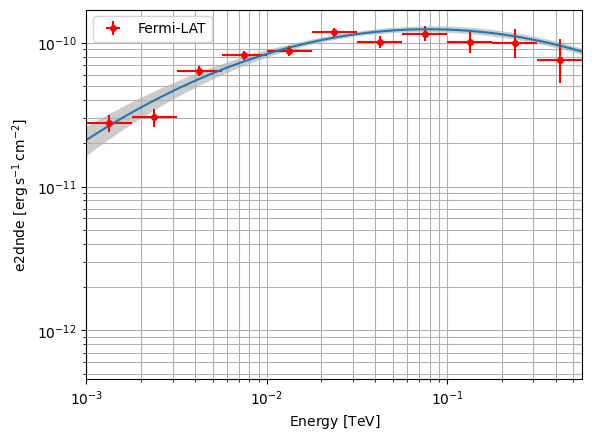

In [45]:
analysis.flux_points[0].plot(sed_type="e2dnde", color="red", label="Fermi-LAT")
analysis.datasets[0].models[config_main.target.source_name].spectral_model.plot(
    sed_type="e2dnde", energy_bounds=[70 * u.MeV,10 * u.TeV]
)
analysis.datasets[0].models[config_main.target.source_name].spectral_model.plot_error(
    sed_type="e2dnde", energy_bounds=[70 * u.MeV,10 * u.TeV]
)

plt.grid(which="both")
plt.legend()

In [46]:
hess_fpt = analysis.flux_points[1].to_table(sed_type="e2dnde", formatted=True)
hess_fpt

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),TeV / (s cm2),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.126,0.100,0.158,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.200,0.158,0.251,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.316,0.251,0.398,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.501,0.398,0.631,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.794,0.631,1.000,5.559e-11,4.624e-12,4.701e-12,4.552e-12,6.517e-11,163.720,12.795,217.9459005380534,188.9387,0.000,False,218.0,True,0.200 .. 5.000,116.758 .. 628.070
1.259,1.000,1.585,3.641e-11,3.887e-12,3.997e-12,3.784e-12,4.463e-11,105.412,10.267,106.994982275757,99.99465,0.000,False,107.0,True,0.200 .. 5.000,70.067 .. 495.082
1.995,1.585,2.512,2.958e-11,4.045e-12,4.160e-12,3.940e-12,3.815e-11,60.827,7.799,79.00124909632217,69.0014,0.000,False,79.0,True,0.200 .. 5.000,40.661 .. 304.480
3.162,2.512,3.981,2.107e-11,3.870e-12,4.008e-12,3.750e-12,2.938e-11,33.206,5.762,47.00618495906516,40.007107,0.000,False,47.0,True,0.200 .. 5.000,21.643 .. 187.735


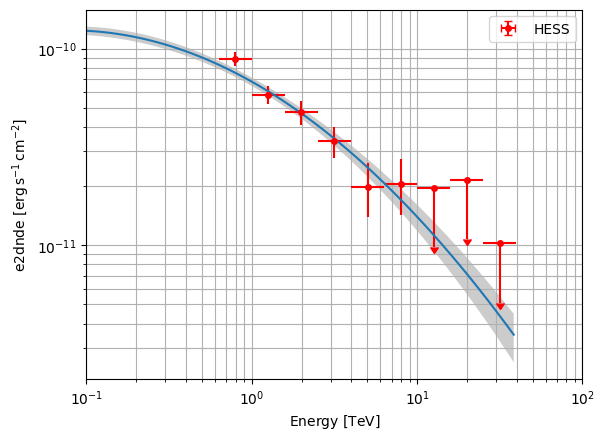

In [47]:
analysis.flux_points[1].plot(sed_type="e2dnde", color="red", label="HESS")
analysis.datasets[1].models[0].spectral_model.plot(
    sed_type="e2dnde", energy_bounds=[10 * u.GeV, 40 * u.TeV]
)
analysis.datasets[1].models[0].spectral_model.plot_error(
    sed_type="e2dnde", energy_bounds=[10 * u.GeV, 40 * u.TeV]
)

plt.grid(which="both")
plt.legend()

# Final SED plot with all instruments

(0.0007, 50.0)

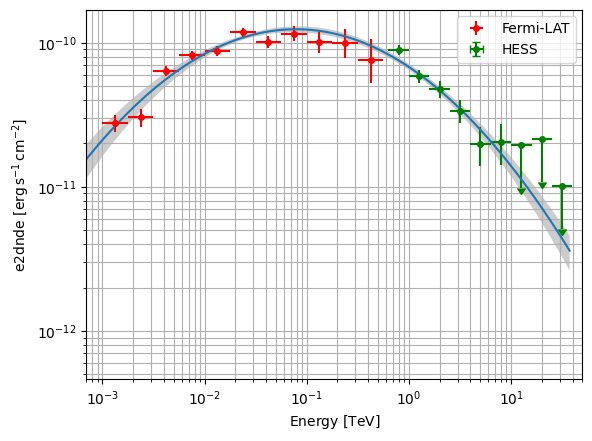

In [48]:
analysis.flux_points[0].plot(sed_type="e2dnde", color="red", label="Fermi-LAT")
analysis.flux_points[1].plot(sed_type="e2dnde", color="green", label="HESS")

analysis.datasets[1].models[0].spectral_model.plot(
    sed_type="e2dnde", energy_bounds=[70 * u.MeV, 40 * u.TeV]
)
analysis.datasets[1].models[0].spectral_model.plot_error(
    sed_type="e2dnde", energy_bounds=[70 * u.MeV, 40 * u.TeV]
)

plt.grid(which="both")
plt.legend()
plt.xlim(7e-4, 5e1)